## Library

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error, r2_score


## Data Import

In [19]:
data_fMRI = pd.read_csv("./data_for_analysis/tsnr_voxel_data.csv")
data_fMRI.head(5)

,Voxel Value,X,Y,Z,Task,Subject
0,NaN,0,0,0,LanguageControl,sub-001
1,NaN,0,0,1,LanguageControl,sub-001
2,NaN,0,0,2,LanguageControl,sub-001
3,NaN,0,0,3,LanguageControl,sub-001
4,NaN,0,0,4,LanguageControl,sub-001


In [20]:
data_fMRI = data_fMRI.dropna(subset=['Voxel Value'])
data_fMRI.shape

(12364487, 6)

In [21]:
data_participants = pd.read_csv("./data_for_analysis/participants.tsv" , sep='\t')
data_participants = pd.DataFrame(data_participants)
data_participants = data_participants.rename(columns={'Chinese_writing': "C_wr", "Chinese_listening":"C_li","Chinese_speaking":"C_sp","Chinese_reading":"C_re",
                                                      "English_writing":"E_wr", "English_listening":"E_li", "English_speaking":"E_sp", "English_reading":"E_re"})
data_participants.head(5)

,participant_id,age,sex,task_order,task_rule,raven_score,AoA,CET_4_score,RT_L1S,RT_L1NS,...,ER_L2S,ER_L2NS,C_re,C_wr,C_sp,C_li,E_re,E_wr,E_sp,E_li
0,sub-001,20,F,Lan,Red,56,12,455,1068,948,...,0.050,0.050,8,7,6,6,4,4,4,4
1,sub-002,24,F,Lan,Red,55,13,576,918,832,...,0.025,0.025,8,7,8,8,5,6,4,4
2,sub-003,24,M,Lan,Red,60,7,543,951,859,...,0.000,0.000,9,7,8,8,9,6,6,7
3,sub-004,21,F,Lan,Red,47,8,564,1101,1023,...,0.050,0.025,7,6,8,7,5,5,4,3
4,sub-005,24,M,Lan,Blue,59,13,539,891,766,...,0.025,0.000,8,8,9,8,5,5,6,5


In [22]:
Language_RT = ["RT_L1S","RT_L1NS","RT_L2S","RT_L2NS"]
Language_ER = ["ER_L1S","ER_L1NS","ER_L2S","ER_L2NS"]

chinese_skills = ["C_wr", "C_li", "C_sp", "C_re"]
english_skills = ["E_wr", "E_li", "E_sp", "E_re"]

participants_pool = data_participants['participant_id'].unique().tolist()

participants_lang = data_participants[ ['participant_id', 'age', 'AoA',"CET_4_score"]+chinese_skills+english_skills+Language_RT+Language_ER]
participants_cog = data_participants[ ['participant_id', 'age', "raven_score"]+Language_RT+Language_ER]

In [23]:
participants_lang.head()

,participant_id,age,AoA,CET_4_score,C_wr,C_li,C_sp,C_re,E_wr,E_li,E_sp,E_re,RT_L1S,RT_L1NS,RT_L2S,RT_L2NS,ER_L1S,ER_L1NS,ER_L2S,ER_L2NS
0,sub-001,20,12,455,7,6,6,8,4,4,4,4,1068,948,1059,1027,0.000,0.000,0.050,0.050
1,sub-002,24,13,576,7,8,8,8,6,4,4,5,918,832,897,823,0.025,0.000,0.025,0.025
2,sub-003,24,7,543,7,8,8,9,6,7,6,9,951,859,883,841,0.000,0.000,0.000,0.000
3,sub-004,21,8,564,6,7,8,7,5,3,4,5,1101,1023,1000,935,0.050,0.075,0.050,0.025
4,sub-005,24,13,539,8,8,9,8,5,5,6,5,891,766,760,784,0.025,0.025,0.025,0.000


In [24]:
participants_cog.head()

,participant_id,age,raven_score,RT_L1S,RT_L1NS,RT_L2S,RT_L2NS,ER_L1S,ER_L1NS,ER_L2S,ER_L2NS
0,sub-001,20,56,1068,948,1059,1027,0.000,0.000,0.050,0.050
1,sub-002,24,55,918,832,897,823,0.025,0.000,0.025,0.025
2,sub-003,24,60,951,859,883,841,0.000,0.000,0.000,0.000
3,sub-004,21,47,1101,1023,1000,935,0.050,0.075,0.050,0.025
4,sub-005,24,59,891,766,760,784,0.025,0.025,0.025,0.000


In [25]:
lang_data = data_fMRI[data_fMRI['Task'] == ("LanguageControl")]
cog_data = data_fMRI[data_fMRI['Task'] == ("CognitiveControl")]

### Voxel Average

In [26]:
voxel_avg_lang = (
    lang_data.groupby(['X', 'Y', 'Z'])['Voxel Value']
    .mean()
    .reset_index()
    .rename(columns={'Voxel Value': 'voxel_avg'})
)

voxel_avg_cog = (
    cog_data.groupby(['X', 'Y', 'Z'])['Voxel Value']
    .mean()
    .reset_index()
    .rename(columns={'Voxel Value': 'voxel_avg'})
)

In [27]:
voxel_avgs = pd.merge(
    voxel_avg_lang,
    voxel_avg_cog,
    on=['X', 'Y', 'Z'],
    suffixes=('_lang', '_cog')
)
voxel_avgs["voxel_diff"] = voxel_avgs["voxel_avg_cog"] - voxel_avgs["voxel_avg_lang"]
lang_voxel = voxel_avgs[voxel_avgs["voxel_avg_lang"] > voxel_avgs["voxel_avg_cog"]]
cog_voxel = voxel_avgs[voxel_avgs["voxel_avg_lang"] < voxel_avgs["voxel_avg_cog"]]
voxel_avgs.head()

,X,Y,Z,voxel_avg_lang,voxel_avg_cog,voxel_diff
0,2,22,16,9.727637,16.693541,6.965904
1,2,22,17,17.039139,13.909820,-3.129319
2,2,22,18,7.222319,14.624842,7.402523
3,2,22,19,24.440159,10.798609,-13.641550
4,2,23,16,21.788323,23.211920,1.423597


In [18]:
print(lang_voxel.shape)
print(cog_voxel.shape)

(1581, 6)
(46507, 6)


In [28]:
fig = px.scatter_3d(
    voxel_avg_lang,
    x='X', y='Y', z='Z',
    color='voxel_avg',
    color_continuous_scale='Viridis',
    opacity=0.6,
    title='3D Voxel Average Intensity'
)

fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    coloraxis_colorbar=dict(title='Voxel Avg')
)

fig.show()
#fig.write_html("lang_voxel_3d_plot.html")

In [29]:
fig = px.scatter_3d(
    voxel_avg_cog,
    x='X', y='Y', z='Z',
    color='voxel_avg',
    color_continuous_scale='Viridis',
    opacity=0.6,
    title='3D Voxel Average Intensity'
)

fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    coloraxis_colorbar=dict(title='Voxel Avg')
)

fig.show()
#fig.write_html("cog_voxel_3d_plot.html")

## Modelings

### Data Prep

In [36]:
train_participants, test_participants = train_test_split(
    participants_pool, test_size=0.2, random_state=42
)

In [11]:
lang_voxel.head()

,X,Y,Z,voxel_avg_lang,voxel_avg_cog,voxel_diff
1,2,22,17,17.039139,13.909820,-3.129319
3,2,22,19,24.440159,10.798609,-13.641550
17,2,24,22,1.163311,0.242185,-0.921126
22,2,25,19,18.705413,17.428268,-1.277145
25,2,25,22,7.524453,5.676629,-1.847824


In [30]:
#data_sub = data_sub['voxel_avg_lang'].mean().reset_index()
data_sub = data_fMRI.rename(columns={'Subject':"participant_id"})

In [31]:
lang = pd.merge(
    participants_lang,
    data_sub,
    on=["participant_id"],
)
lang = lang[lang['Task'] == 'LanguageControl'].drop(columns=['Task'])

lang.head()

,participant_id,age,AoA,CET_4_score,C_wr,C_li,C_sp,C_re,E_wr,E_li,...,RT_L2S,RT_L2NS,ER_L1S,ER_L1NS,ER_L2S,ER_L2NS,Voxel Value,X,Y,Z
0,sub-001,20,12,455,7,6,6,8,4,4,...,1059,1027,0.0,0.0,0.05,0.05,20.975027,2,23,16
1,sub-001,20,12,455,7,6,6,8,4,4,...,1059,1027,0.0,0.0,0.05,0.05,9.467050,2,23,17
2,sub-001,20,12,455,7,6,6,8,4,4,...,1059,1027,0.0,0.0,0.05,0.05,9.622909,2,24,16
3,sub-001,20,12,455,7,6,6,8,4,4,...,1059,1027,0.0,0.0,0.05,0.05,5.989080,2,24,17
4,sub-001,20,12,455,7,6,6,8,4,4,...,1059,1027,0.0,0.0,0.05,0.05,7.492095,2,24,18


In [34]:
lang_d = pd.merge(
    lang,
    lang_voxel,
    on=["X","Y","Z"],
)
lang_d.head()
#.drop(columns=['Task'])

,participant_id,age,AoA,CET_4_score,C_wr,C_li,C_sp,C_re,E_wr,E_li,...,ER_L1NS,ER_L2S,ER_L2NS,Voxel Value,X,Y,Z,voxel_avg_lang,voxel_avg_cog,voxel_diff
0,sub-001,20,12,455,7,6,6,8,4,4,...,0.0,0.05,0.05,19.126356,2,26,17,21.522416,20.576480,-0.945936
1,sub-001,20,12,455,7,6,6,8,4,4,...,0.0,0.05,0.05,7.012584,2,27,16,20.254796,19.658668,-0.596128
2,sub-001,20,12,455,7,6,6,8,4,4,...,0.0,0.05,0.05,11.241770,2,27,17,14.667554,12.739895,-1.927660
3,sub-001,20,12,455,7,6,6,8,4,4,...,0.0,0.05,0.05,21.101156,2,28,16,9.015175,7.141506,-1.873669
4,sub-001,20,12,455,7,6,6,8,4,4,...,0.0,0.05,0.05,5.587487,2,28,17,10.383424,9.734275,-0.649149


In [33]:
cog = pd.merge(
    participants_cog,
    data_sub,
    on=["participant_id"],
)
cog = cog[cog['Task'] == 'CognitiveControl'].drop(columns=['Task'])

cog.head()

,participant_id,age,raven_score,RT_L1S,RT_L1NS,RT_L2S,RT_L2NS,ER_L1S,ER_L1NS,ER_L2S,ER_L2NS,Voxel Value,X,Y,Z
79999,sub-001,20,56,1068,948,1059,1027,0.0,0.0,0.05,0.05,24.729603,2,25,17
80000,sub-001,20,56,1068,948,1059,1027,0.0,0.0,0.05,0.05,18.996946,2,26,17
80001,sub-001,20,56,1068,948,1059,1027,0.0,0.0,0.05,0.05,30.346338,2,26,19
80002,sub-001,20,56,1068,948,1059,1027,0.0,0.0,0.05,0.05,39.731766,2,27,16
80003,sub-001,20,56,1068,948,1059,1027,0.0,0.0,0.05,0.05,14.886698,2,27,17


In [35]:
cog_d = pd.merge(
    cog,
    cog_voxel,
    on=["X","Y","Z"],
)
cog_d.head()

,participant_id,age,raven_score,RT_L1S,RT_L1NS,RT_L2S,RT_L2NS,ER_L1S,ER_L1NS,ER_L2S,ER_L2NS,Voxel Value,X,Y,Z,voxel_avg_lang,voxel_avg_cog,voxel_diff
0,sub-001,20,56,1068,948,1059,1027,0.0,0.0,0.05,0.05,24.729603,2,25,17,20.076196,25.595233,5.519037
1,sub-001,20,56,1068,948,1059,1027,0.0,0.0,0.05,0.05,30.346338,2,26,19,20.991231,22.436194,1.444963
2,sub-001,20,56,1068,948,1059,1027,0.0,0.0,0.05,0.05,15.310585,2,27,18,18.755495,22.537086,3.781591
3,sub-001,20,56,1068,948,1059,1027,0.0,0.0,0.05,0.05,47.062122,2,27,19,21.220554,25.882250,4.661695
4,sub-001,20,56,1068,948,1059,1027,0.0,0.0,0.05,0.05,28.323431,2,27,20,9.512726,10.771517,1.258790


### Brain Activation Prediction


Goal: Predict brain activity (Voxel Value) from cognitive and behavioral measures.

Approach:

Target: Voxel Value

Features: age, raven_score, RT_*, ER_*, possibly voxel coordinates (X, Y, Z)

Models: Linear Regression, Random Forest

In [51]:
# Define feature list
features = [
    'age', 'AoA', 'CET_4_score',
    'RT_L1S', 'RT_L1NS', 'RT_L2S', 'RT_L2NS',
    'ER_L1S', 'ER_L1NS', 'ER_L2S', 'ER_L2NS',
    'X', 'Y', 'Z'
]

# Ensure all features and 'Voxel Value' exist in the DataFrame
available_features = [f for f in features if f in lang.columns]
df_corr = lang[available_features + ['Voxel Value']]

# Compute correlations
correlations = df_corr.corr(method='pearson')

# Display correlations with Voxel Value
voxel_corr = correlations['Voxel Value'].drop('Voxel Value').sort_values(key=abs, ascending=False)
print("Correlation with Voxel Value:")
print(voxel_corr)


Correlation with Voxel Value:
Z              0.300228
age           -0.052871
RT_L1NS       -0.029520
ER_L1NS        0.027450
RT_L1S        -0.026134
CET_4_score    0.023515
Y              0.022871
ER_L2S        -0.019040
X              0.018098
ER_L1S         0.017382
RT_L2S        -0.011583
AoA           -0.009955
RT_L2NS       -0.008274
ER_L2NS       -0.000077
Name: Voxel Value, dtype: float64


In [53]:
# Define feature list
features_cog = [
    'age', 'raven_score',
    'RT_L1S', 'RT_L1NS', 'RT_L2S', 'RT_L2NS',
    'ER_L1S', 'ER_L1NS', 'ER_L2S', 'ER_L2NS',
    'X', 'Y', 'Z'
]

# Ensure all features and 'Voxel Value' exist in the DataFrame
available_features_cog = [f for f in features_cog if f in cog.columns]
df_corr_cog = cog[available_features_cog + ['Voxel Value']]

# Compute correlations
correlations_cog = df_corr_cog.corr(method='pearson')

# Display correlations with Voxel Value
voxel_corr_cog = correlations_cog['Voxel Value'].drop('Voxel Value').sort_values(key=abs, ascending=False)
print("Correlation with Voxel Value:")
print(voxel_corr_cog)

Correlation with Voxel Value:
Z              0.297386
age           -0.047719
RT_L1NS       -0.035423
ER_L1NS        0.028808
RT_L1S        -0.027259
ER_L2S        -0.025034
RT_L2S        -0.022420
RT_L2NS       -0.021502
Y              0.019968
X              0.017925
ER_L2NS       -0.014747
raven_score    0.013624
ER_L1S         0.010534
Name: Voxel Value, dtype: float64


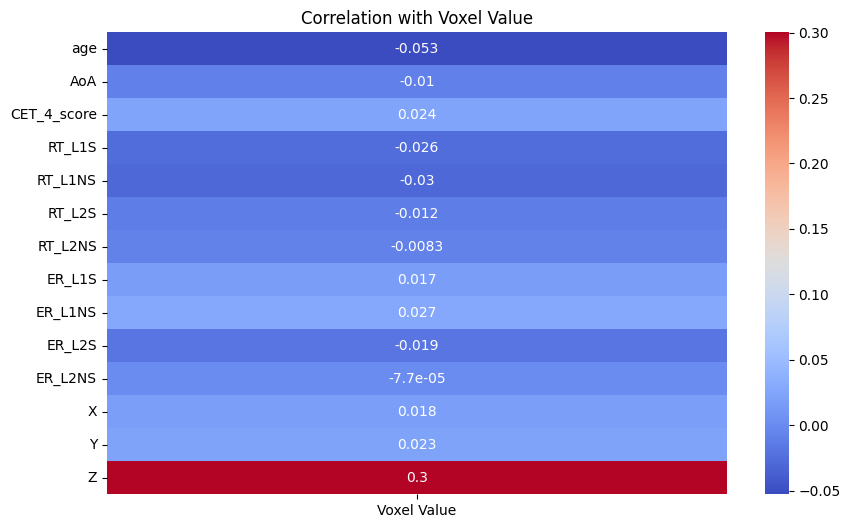

In [52]:
plt.figure(figsize=(10, 6))
sns.heatmap(correlations[['Voxel Value']].drop(index='Voxel Value'), annot=True, cmap='coolwarm')
plt.title("Correlation with Voxel Value")
plt.show()

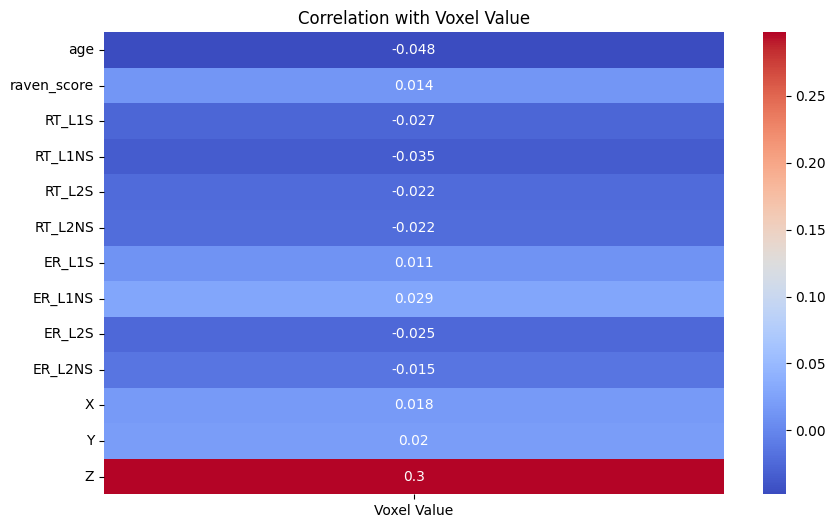

In [54]:
plt.figure(figsize=(10, 6))
sns.heatmap(correlations_cog[['Voxel Value']].drop(index='Voxel Value'), annot=True, cmap='coolwarm')
plt.title("Correlation with Voxel Value")
plt.show()

In [ ]:
# Filter training and testing data based on participant_id
train_df = lang[lang['participant_id'].isin(train_participants)].copy()
test_df = lang[lang['participant_id'].isin(test_participants)].copy()

# Drop non-feature columns
feature_cols = [
    'age', 'AoA', 'CET_4_score',
    'RT_L1S', 'RT_L1NS', 'RT_L2S', 'RT_L2NS',
    'ER_L1S', 'ER_L1NS', 'ER_L2S', 'ER_L2NS',
    'X', 'Y', 'Z'
]

X_train = train_df[feature_cols]
y_train = train_df['Voxel Value']
X_test = test_df[feature_cols]
y_test = test_df['Voxel Value']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [42]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

print("Linear Regression:")
print("  RMSE:", root_mean_squared_error(y_test, y_pred_lr))
print("  R^2:", r2_score(y_test, y_pred_lr))

Linear Regression:
  RMSE: 36.60894800041638
  R^2: 0.07031314471246697


In [ ]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

print("\nRandom Forest:")
print("  RMSE:", root_mean_squared_error(y_test, y_pred_rf, squared=False))
print("  R^2:", r2_score(y_test, y_pred_rf))


### Brain Region Analysis

Goal: Understand how behavioral metrics relate to brain activation across regions.

Approach:

Group by voxel coordinates or brain regions (if you map X/Y/Z to regions)

Use statistical modeling (e.g., mixed-effects models) or clustering to find patterns

In [47]:
import statsmodels.api as sm

# Group by spatial coordinates (voxel region)
voxel_groups = cog.groupby(['X', 'Y', 'Z'])

# Store region-level regression results
region_results = []

# Features to use
predictor_cols = ['age', 'raven_score', 'RT_L1S', 'RT_L1NS', 'RT_L2S', 'RT_L2NS',
                  'ER_L1S', 'ER_L1NS', 'ER_L2S', 'ER_L2NS']

# Loop over voxel regions
for (x, y, z), group in voxel_groups:
    if len(group) < 10:
        continue  # skip very small groups to avoid unstable models

    X = group[predictor_cols]
    X = sm.add_constant(X)  # add intercept
    y = group['Voxel Value']

    model = sm.OLS(y, X).fit()
    r2 = model.rsquared
    p_raven = model.pvalues.get('raven_score', None)

    region_results.append({
        'X': x,
        'Y': y,
        'Z': z,
        'R^2': r2,
        'p_raven': p_raven
    })

# Create DataFrame with results
region_df = pd.DataFrame(region_results)

# Sort and display strongest regions by R^2
region_df.sort_values('R^2', ascending=False).head()


,X,Y,Z,R^2,p_raven
5554,11,84747 10.285531 124529 9.753035 15...,6,0.999886,1.000763e-02
12282,17,2678236 -3.516355 2718635 -3.963090 39...,35,0.999481,6.510232e-08
39397,38,1292872 5.391560 1581497 14.125231 36...,33,0.998782,1.158877e-02
19142,22,3318715 10.933249 3676578 26.623892 3791...,36,0.998703,9.321682e-03
43375,42,118376 28.558586 276334 14.495798 31...,16,0.998535,1.283306e-04


In [48]:
region_df.head()

,X,Y,Z,R^2,p_raven
0,2,277774 17.085236 722423 26.296110 15...,17,0.876525,0.101418
1,2,237998 19.129654 277775 9.174898 14...,16,0.723839,0.041904
2,2,237999 23.957453 277776 19.551014 60...,17,0.366132,0.227701
3,2,277777 16.600779 600014 -0.057917 72...,18,0.727771,0.421075
4,2,1420625 20.933872 1544634 3.359763 15...,19,0.657955,0.564448


In [49]:
fig = plt.figure(figsize=(8, 6))
sns.scatterplot(data=region_df, x='X', y='Y', hue='R^2', size='R^2', palette='viridis')
plt.title("Brain Region Analysis: R² values across voxel locations")
plt.xlabel("X (voxel space)")
plt.ylabel("Y (voxel space)")
plt.legend(title='R²')
plt.show()

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

<Figure size 800x600 with 0 Axes>